# Homework 1: Numpy, Scipy, Pandas

### Due Tues Feb 1, 2022 @ 8pm


## Questions

1. All the convolutions are centered at image center - why? I got around this by subtracting the autocorrelation, and indeed the convolutions then found the proper peaks.

2. Are we supposed to have to modify Audio() to get it to work? or is it a browser issue? All I did was Audio(path/to/file.wav)

3. Why are all my audio recordings SUPER LOUD and railing against the limits of my speakers?  This is true even for the zero-compression case, in which I checked that the output waveform is identical to the input... feels like an i/o issue and not sure it's my fault necessarily

## #0: Get set up with your environment to work on and submit homework

a. Create a new homework repository at github

<img src="data/screenshot_1.png">

Name your repo something sensible (e.g., python-ay250-homeworks). Given your Berkeley affiliation you should be able to get private repos if you'd like.

<img src="data/screenshot_2.png">


b. Clone this repo locally and make a directory for this week's homework:

```bash
cd /class/directories ## this will be different on your machine...whereever you want to keep your work.

# change <username> to your github username:
git clone https://github.com/<username>/python-ay250-homework.git
cd python-ay250-homework
mkdir hw_1
echo "hw_1 README" >> hw_1/README.md
git add hw_1/README.md
git commit hw_1/README.md -m "added hw_1 directory"
git push
```

c. Copy this notebook into your `hw_1` folder from a local version of the python-seminar repo

```bash
cd /class/directories
git clone https://github.com/profjsb/python-seminar.git 
cd python-seminar
git pull
cp -r Homeworks/hw_1/* /class/directories/python-ay250-homework/hw_1/
```

d. Get working! Be sure to check in your work as often as you'd like

```bash
cd /class/directories/python-ay250-homework
git add hw_1/<whatever>
git commit <whatever> -m "this is a check in"
git push
```

e. To submit your work, go to this form to register your homework Repo URL (https://forms.gle/z9XZqCD5Ra9ikTGQ8). If you've made your repo private, you'll need to add us as collaborators to the repo.  Our Github handles are `@profjsb` and `@elliesch`.

## #1:  Super-resolution imaging 

Obtaining several snapshots of the same scene, from microscopes to telescopes, is useful for the postprocessing increase of signal to noise: by summing up imaging data we can effectively beat down the noise. Interestingly, if we image the same scene from different vistas we can also improve the clarity of the combined image. Being able to discern features in a scene from this combination effort is sometimes called super-resolution imaging.

Here, we'll combine about 4 seconds of a shaky video to reveal the statement on a license plate that is not discernable in any one frame.

<img src="Data/im2-1.png">

A tarball of the data is at: https://zenodo.org/record/5889322/files/homework1_data.tgz?download=1 (Zenodo page for the course: https://zenodo.org/record/5889322). This file is also in the read-only directory on `astro.datahub.berkeley.edu`.

```bash
tar -xvzf homework1_data.tgz  # do NOT check this files into git...
```

**Problem 1** Read in each image into a `numpy` array. Resize each frame to be 3 times larger in each axis (ie. 9 times larger images). Using `scipy.signal.fftconvolve` find the offsets of each frame with respect to the first frame. Report those offsets to 2 decimal places. 

   - Hint0: you can use `PIL` to read the images or `matplotlib.pyplot.imread`
```python
from PIL import Image
array = Image.open(fname).convert('L')
```
   - Hint1: you'll need to figure out how to resize a numpy array. Check out PIL.Image.resize...
   - Hint2: you'll want to reverse the second image when doing the convolution: `scipy.signal.fftconvolve(im1, im2[::-1, ::-1])`
   - Hint3: you'll need to figure out how to identify the peak of the fft convolution to find the offsets between images

In [210]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
from scipy import signal, interpolate, ndimage

In [211]:
input_dir = '/home/jovyan/data/hw1_data/'
all_filenames = np.asarray(os.listdir(input_dir))
good_filenames = np.asarray([s.startswith('im2-') for s in all_filenames])
filenames_in = all_filenames[good_filenames]
sort_indices = np.argsort(np.asarray([int(s.split('-')[1].split('.')[0]) for s in filenames_in]))
filenames_in = filenames_in[sort_indices]

In [212]:
def crop_center(img,cropx,cropy):
    x,y = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[startx:startx+cropx,starty:starty+cropy]

In [213]:
def load_and_resize(fname, size_multiplier = 3, crop_bounds = False):
    '''
    takes in a fname for a frame of the video,
    resizes it to given size,
    returns as np array
    '''
    array_in = Image.open(fname).convert('L')
    newsize = (size_multiplier*array_in.size[0], size_multiplier*array_in.size[1])
    array_big = array_in.resize(newsize, resample = Image.NEAREST)
    array_big = np.asarray(array_big)
        
    # remove the empty edges - they may screw up the convolution
    # all those edges are where the array is identically equal to 255
    bad_map = (array_big == 255).astype(int)
    changepoints = np.nonzero(bad_map[1:,0] - bad_map[:-1,0])[0]
    array_big = array_big[changepoints[0]:changepoints[1],:]
    
    if crop_bounds:
        array_big = crop_center(array_big, crop_bounds[0], crop_bounds[1])
    
    return array_big

In [214]:
def compute_shift(frame, frame0, fine_scale = False):
    '''
    take in two frames, returns the optimal x and y distance to move them to stack on top of each other
    '''
    
    convolution = signal.fftconvolve(frame, frame0[::-1,::-1], mode='same')
    autocorrelation = signal.fftconvolve(frame, frame[::-1, ::-1], mode='same')
    diff = convolution - autocorrelation
    # this seems to work
    
    # try high pass filtering to get peaky behavior
    lowpass = ndimage.gaussian_filter(diff, 3)
    gauss_highpass = diff - lowpass
    diff = gauss_highpass
    # this helps, but it destroys sub-pixel information
    # although it does not look like the sub-pixel information attempt is doing anything
    
    max_idx = np.argwhere(diff == np.max(diff))[0]
    
    # try fitting the peak of the correlation with the peak of the autocorrelation
    
    # this does not seem to improve anything, even if we do not apply the high pass filter
    if fine_scale:
        # try an interpolation function to find the max correlation at sub px level
        xx = np.arange(0, diff.shape[0], 1)
        yy = np.arange(0, diff.shape[1], 1)
        interpf = interpolate.RectBivariateSpline(xx, yy, diff)
        
        # the problem is how to find x,y of the maximum without just testing lots of points
        # try supersampling a small box around maximum of convolution
        conv_center = diff[max_idx[0]-2:max_idx[0]+2, max_idx[1]-2:max_idx[1]+2]
        #linspace includes endpoint. this is 5 pixels supersampled by factor of 100
        xx_hires = np.linspace(max_idx[0]-2, max_idx[0]+2, 500) 
        yy_hires = np.linspace(max_idx[1]-2, max_idx[1]+2, 500)
        hi_res_center = interpf(xx_hires, yy_hires)
        #plt.imshow(hi_res_center)
        #plt.show()
        center_idx = np.argwhere(hi_res_center == np.max(hi_res_center))[0]
        small_x, small_y = center_idx[0] / 100., center_idx[1] / 100.
        x, y = small_x + max_idx[0] - 2.5, small_y + max_idx[1] - 2.5
        dx, dy = x - diff.shape[0]/2, y - diff.shape[1]/2
    else:
        dx, dy = max_idx[0] - diff.shape[0]/2, max_idx[1] - diff.shape[1]/2
    
    
    return dx, dy, diff
    

In [215]:
def apply_shift(frame, dx, dy):
    '''
    applies a sub-pixel shift to an image
    '''
    shifted_frame = ndimage.interpolation.shift(frame, (dx, dy))
    
    return shifted_frame
    

In [216]:
def display_conv(conv_list, label_list = False, cmap = cm.cividis, crop_bounds = False):
    '''Make pretty 2-D plots of the convolutions we are getting
    accepts a list of 2-D np arrays'''
    n_subplots = len(conv_list)
    fig, axes = plt.subplots(1, n_subplots, figsize = (6*n_subplots, 7))

    for i in range(n_subplots):
        ax = axes.flatten()[i]
        if crop_bounds:
            display_im = crop_center(conv_list[i], crop_bounds[0], crop_bounds[1])
        else:
            display_im = conv_list[i]
        ax.imshow(display_im, cmap = cmap)
        if label_list:
            ax.set_title(label_list[i])
        ax.set_xticks([])
        ax.set_yticks([])
                 
    plt.show()
    return

39.99000000000001 29.99000000000001


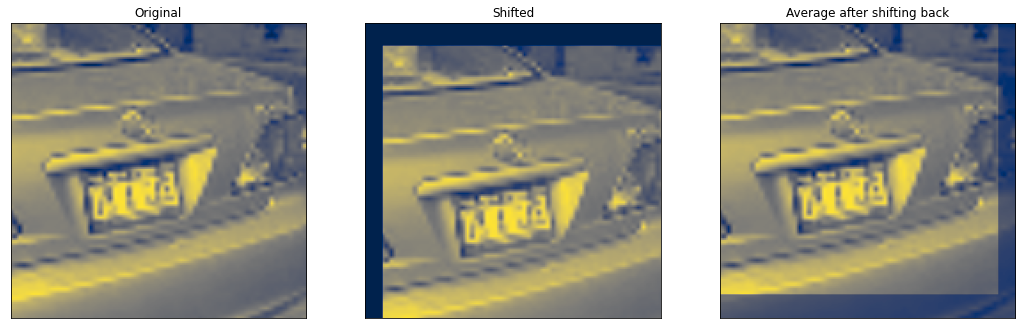

In [217]:
## purely for testing, show autocorrelation with a known offset of a few pixels
shifted_frames = []
size_multiplier = 3
crop_bounds = [500, 500]
frame0 = load_and_resize(input_dir + filenames_in[0], size_multiplier = size_multiplier, crop_bounds = crop_bounds)
frame1 = np.pad(frame0, 40)[:-80, 10:-70]
dx,dy,conv_autocorrelation = compute_shift(frame1, frame0, fine_scale = True)
print(dx, dy)

shifted_1 = apply_shift(frame1, -dx, -dy)
summed_frames = np.mean(np.asarray([frame0, shifted_1]), axis = 0)

display_conv([frame0, frame1, summed_frames], label_list = ['Original', 'Shifted', 'Average after shifting back'])

# this works seemingly to around the tenth-pixel level           

File im2-1.png requires a shift of (-8.960000000000008, 39.04000000000002)
File im2-2.png requires a shift of (-120.07, 6.029999999999973)
File im2-3.png requires a shift of (-177.05, -33.03)
File im2-4.png requires a shift of (-0.0800000000000125, -9.110000000000014)
File im2-5.png requires a shift of (-8.939999999999998, -32.93000000000001)
File im2-6.png requires a shift of (-135.05, -71.99000000000001)
File im2-7.png requires a shift of (0.0, 120.02999999999997)
File im2-8.png requires a shift of (-65.91, 38.879999999999995)
File im2-9.png requires a shift of (0.030000000000001137, 80.98000000000002)
File im2-10.png requires a shift of (-105.0, 8.95999999999998)
File im2-11.png requires a shift of (-56.96000000000001, 167.91000000000003)
File im2-12.png requires a shift of (-63.03999999999999, 24.079999999999984)
File im2-13.png requires a shift of (-24.099999999999994, 104.91000000000003)
File im2-14.png requires a shift of (-56.94999999999999, 8.930000000000007)
File im2-15.png r

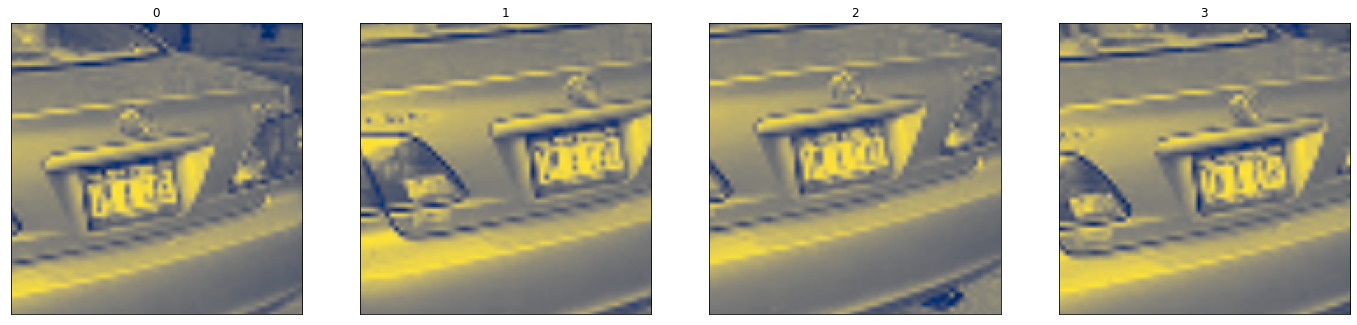

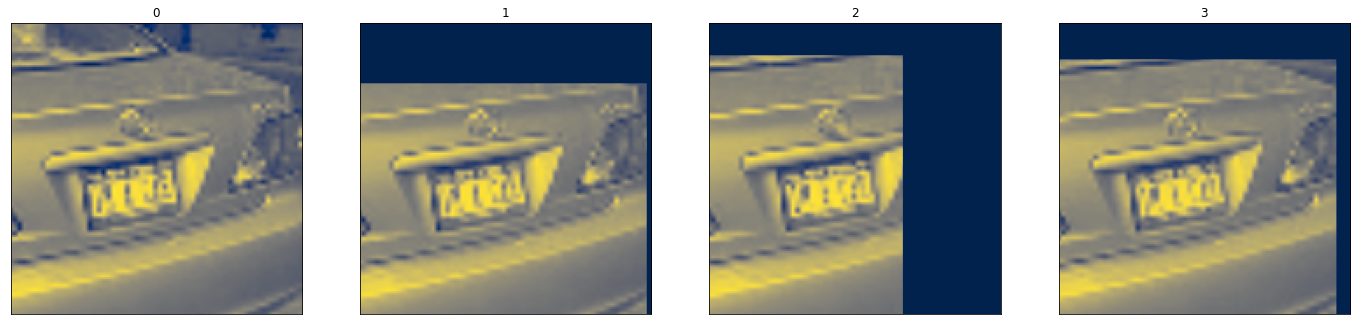

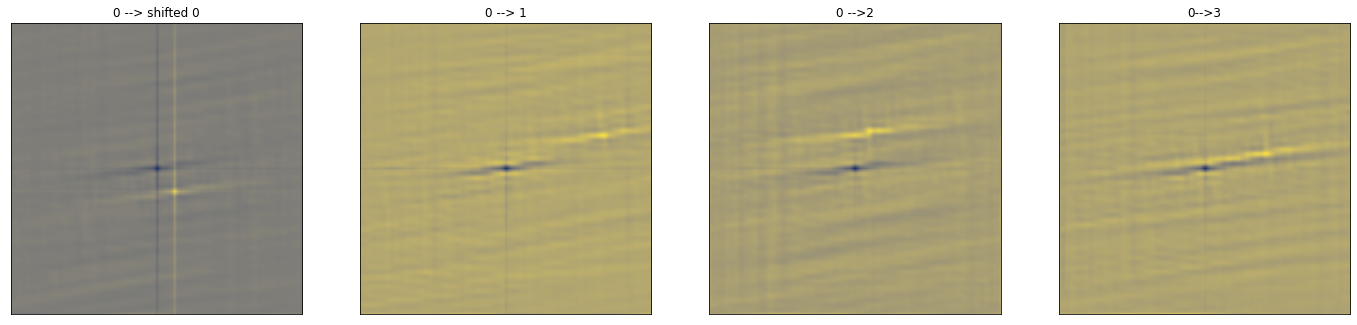

In [218]:
original_frames = []
convolutions = []
size_multiplier = 3
frame0 = load_and_resize(input_dir + filenames_in[0], size_multiplier = size_multiplier, crop_bounds = crop_bounds)
shifted_frames = np.empty((len(filenames_in), frame0.shape[0], frame0.shape[1]))
shifted_frames[0] = frame0

for i in range(1,len(filenames_in)):
#for i in range(1,4):
    fname_in = input_dir + filenames_in[i]
    frame = load_and_resize(fname_in, size_multiplier = size_multiplier, crop_bounds = crop_bounds)
    dx,dy,conv = compute_shift(frame, frame0, fine_scale = True)
    print(f"File {filenames_in[i]} requires a shift of {dx, dy}")
    
    shifted_frame = apply_shift(frame, -dx, -dy)
    #plt.imshow(shifted_frame)
    #plt.show()
    if shifted_frame.shape == frame0.shape:
        original_frames.append(frame)
        shifted_frames[i] = shifted_frame
        convolutions.append(conv)
    
display_conv([frame0] + original_frames[10:13], label_list = ['0', '1', '2', '3'])
display_conv([frame0] + list(shifted_frames[10:13]), label_list = ['0', '1', '2', '3'])    
display_conv([conv_autocorrelation] + convolutions[10:13], 
             label_list = ['0 --> shifted 0', '0 --> 1', '0 -->2', '0-->3'])




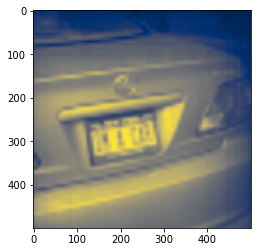

In [219]:
shifted_frames = np.asarray(shifted_frames)
summed_frame = np.mean(shifted_frames, axis = 0)
plt.imshow(summed_frame, cmap = cm.cividis)
plt.show()

It says, "IM A CAR".  I'm sure this can be sharpened a lot by getting the sub-pixel shift right. My attempt did not really work.  One idea would be to fit the peak of the correlation to the peak of the autocorrelation to the sub-pixel level

**Problem 2** Shift each image to register the frames to the original (expanded in size) frame. You should, in general, be shifting by subpixel offsets. You might want to look at `scipy.ndimage.interpolation.shift`

See above

**Problem 3** Combine all the registered images to form a super-resolution image. What does the license plate read?

See above

# #2: An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [221]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

We define a simple utility function to listen to audio files right in the browser:

In [222]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [223]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x, Fs=2)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

**Problem 1**: Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `Homeworks/hw1/data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [224]:
input_dir = '/home/jovyan/data/hw1_data/'
Audio(input_dir+'voice.wav')

**Problem 2**: Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [225]:
from scipy import fft
from scipy.io import wavfile

In [226]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    transform = fft.rfft(x)
    power_indices = np.argsort(np.abs(transform)) #need to use absolute value to correctly order most/least important
    print(f'Dropping {int(fraction * power_indices.size)} of {power_indices.size} values')
    indices_kill = power_indices[:int(fraction * power_indices.size)] #want to DROP that fraction, and keep the largest powers which are last
    
    transform_compressed = np.copy(transform)
    transform_compressed[indices_kill] = 0.0
    x_compressed = fft.irfft(transform_compressed, len(x))
    return x_compressed

As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

In [227]:
x = np.random.rand(128)

Dropping 26 of 65 values


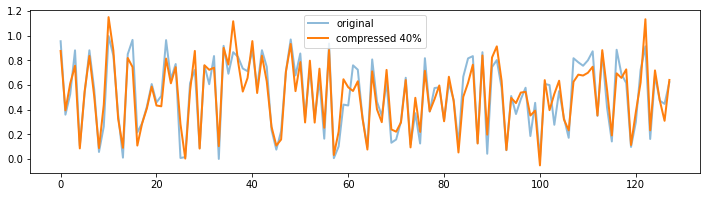

In [228]:
fraction = 0.4 # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();



**Problem 3**: Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [229]:
def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    
    rate, x = wavfile.read(fname)
    x_approx = compress_signal(x, fraction)
    new_fname = fname.split('/')[-1][:-4] + '_comp_%s.wav'%fraction
    wavfile.write(new_fname, rate, x_approx)
    
    return x, x_approx, new_fname, rate

Dropping 0 of 36865 values
16000 voice_comp_0.0.wav


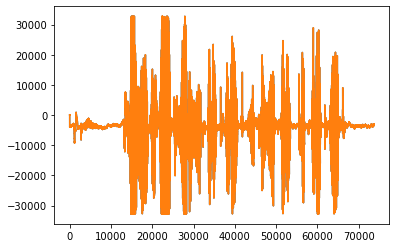

In [230]:
# test the above
input_dir = '/home/jovyan/data/hw1_data/'
x, x_approx, new_fname, rate = compress_wav(input_dir+'voice.wav', 0.0)
print(rate, new_fname)

plt.plot(x)
plt.plot(x_approx)
plt.show()

**Problem 4**: Study the effect of compressing the input file at different ratios: 0.1, 0.5, 0.75, 0.9, 0.95, 0.99.

Using the `OrderedDict` class from the [Python collections module](https://docs.python.org/3/library/collections.html#collections.OrderedDict), store the uncompressed signal as well as the compressed array and filename for each compression ratio.

You will create an `OrderedDict` called `voices`, with:

- keys: compression ratios
- values: pairs of (x, filename) where x is the compressed audio and filename is the name of the compressed file.

In [231]:
from collections import OrderedDict
voices = OrderedDict()

for ratio in [0.0,0.1, 0.5, 0.75, 0.9, 0.95, 0.99]:
    x, x_approx, new_fname, rate = compress_wav('/home/jovyan/data/hw1_data/voice.wav', ratio)
    voices[ratio] = (x_approx, new_fname)

Dropping 0 of 36865 values
Dropping 3686 of 36865 values
Dropping 18432 of 36865 values
Dropping 27648 of 36865 values
Dropping 33178 of 36865 values
Dropping 35021 of 36865 values
Dropping 36496 of 36865 values


**Problem 5**: Loop over the `voices` dict, and for each one generate an audio player as well as a spectrogram.  Observe how the spectrogram changes, and listen to each file.  At what ratio do you stop understanding the recording?

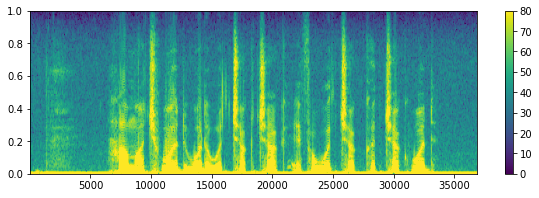

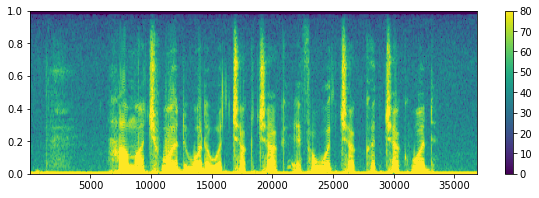

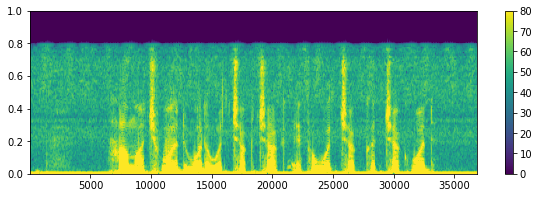

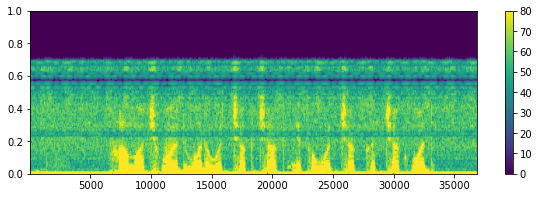

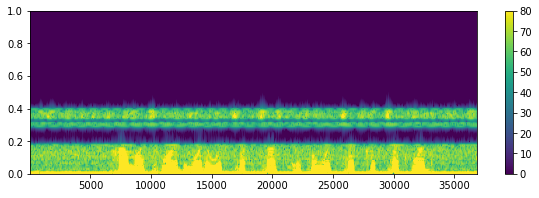

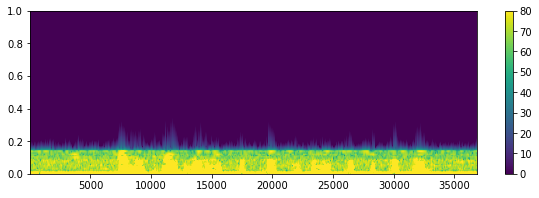

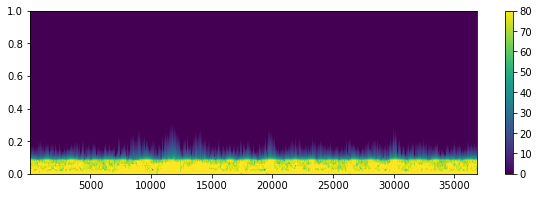

In [232]:
for key, value in voices.items():
    Audio(value[1])
    specgram_cbar(value[0], title=None, clim=(0, 80) )

Amazingly, I can still understand the words all the way until 0.95 compression!  At 0.99 I cannot anymore

# #3: Armchair Astronomer

Often times, people act as good sensors of the physical universe. We can use Google Trends data to help us determine some fundamental parameters of the Solar System.

**Problem 1**: Using just the CSV file we created in the pandas lecture (`merged_data.csv`) and some frequency analysis tools in `scipy` to determine:

   - the number of days in a year
   - the period of the moon's orbit around the Earth
   
Hint: `from scipy.signal.spectral import lombscargle` (you'll want to normalize your signal so it has a mean of zero.)

Five largest spikes (from biggest to smallest) in tennis are at [370.         355.49019608 183.13131313 385.74468085 342.0754717 ] days
Five largest spikes (from biggest to smallest) in icecream are at [370.         355.49019608 385.74468085 342.0754717  402.88888889] days
Five largest spikes (from biggest to smallest) in moon are at [29.57585644 29.4796748  29.67266776 29.38411669 29.77011494] days


/tmp/ipykernel_37/2584533397.py:29: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim([0,1000])


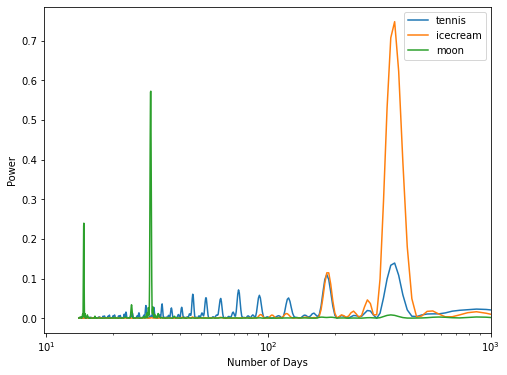

In [233]:
from astropy.timeseries import LombScargle
from datetime import datetime, timedelta
infile = '/home/jovyan/data/hw1_data/merged_data.csv'
data = np.genfromtxt(infile, skip_header = 1, delimiter = ',', dtype = [('date','datetime64[D]'),('tennis','<i8'),('icecream','<i8'),('moon','<i8')])

stepsize = data['date'][1:] - data['date'][:-1]
#print(stepsize)
# ok so its just every week

columns_of_interest = ['tennis', 'icecream', 'moon']
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
for i in range(len(columns_of_interest)):
    
    label = columns_of_interest[i]
    frequency, power = LombScargle(np.arange(data['date'].size), data[label]).autopower()
    days = 7/frequency
    good = days > 14 #since our time resolution is 7 days anything smaller is useless by Nyquist sampling
    power = power[good]
    days = days[good]
    ax.semilogx(days, power, label = label)
    #ax.plot(data['date'], data[label], label = label)
    
    sortidx = np.argsort(power)
    print(f'Five largest spikes (from biggest to smallest) in {label} are at {days[sortidx][-5:][::-1]} days')

ax.legend()
ax.set_xlabel('Number of Days')
ax.set_ylabel('Power')
ax.set_xlim([0,1000])

plt.show()


Based on the above periodogram, the year is 370 days long, since that is the strongest recurrence in both tennis and ice cream. We did not get to pandas in class, so I have no clue what the columns refer to, but they are human phenomena, so we assume they recur based on the Earth year. There is some uncertainty: the peak is pretty wide. This makes sense because we are only using weekly data and there are not many years of data.  The lunar orbit is 29 1/2 days; the second spike looks like its first harmonic. 